In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb

*Load specific modules used here:*

In [2]:
os.chdir(main)
%run stdPlotting.ipynb
os.chdir(d['py'])
import mCGE

# NCP CGE - shock

*Load model:*

In [3]:
name = 'NCPcge'
M = mCGE.NCP_CGE.load(os.path.join(d['data'], name))
ws = M.ws
db0 = M.db.copy() # initial solution

## 1. Define optimal regulation absent emission targets

It can be quite tricky to "optimize" the system of policies. Here, we optimize the system by iterating through years:

In [4]:
# instruments = M.g('output', m = 'P') # production taxes
# fullCondition = ('and', [instruments, M.g('t0')]) 
# M.welModule.policy = [('tauS', fullCondition)]
# M.welModule.initGroups() # re-initialzie groups
# M.opt = True # 
# M.db.mergeInternal()

Solve for optimal taxes and store a checkpoint:

In [5]:
# cp = ws.add_checkpoint()
# M.job = M.ws.add_job_from_string(M.write())
# M.job.run(databases = M.db.database, checkpoint = cp) # store checkoint

Write loop text that gradually opens up for additional policies. From 2075 and onwards 

In [6]:
# loopText = f"""
# Scalar tempScalar;
# for (tempScalar = 2020 to 2090,
#     tauS.lo[t,s,n]$(({gmsPython.gmsWrite.Syms.point(instruments)}) and (t.val = tempScalar)) = -inf;
#     tauS.up[t,s,n]$(({gmsPython.gmsWrite.Syms.point(instruments)}) and (t.val = tempScalar)) = inf;
#     {M.solveStatement()}
# );

# # Sets tempSubseti[t], tempSubsetii[t];

# # tempSubseti[t] = yes$(t.val > 2060);
# # tempSubsetii[t]= yes$(t.val = 2060);


# # tauS.lo[t,s,n]$(({gmsPython.gmsWrite.Syms.point(instruments)}) and (t.val>2059)) = -inf;
# # tauS.up[t,s,n]$(({gmsPython.gmsWrite.Syms.point(instruments)}) and (t.val>2059)) = inf;

# # equation E_temporary;
# # E_temporary[t,s,n]$({gmsPython.gmsWrite.Syms.point(instruments)} and tempSubseti[t]).. tauS[t,s,n] =E= sum(tt$(tempSubsetii[tt]), tauS[tt,s,n]);

# # Model M_temporary /
# # {M.modelName()}, E_temporary
# # /;

# # {M.solveStatement().replace(M.modelName(), 'M_temporary')};

# """

Run:

In [7]:
# M.job = M.ws.add_job_from_string(loopText, checkpoint = cp)
# M.job.run(checkpoint = cp)
# optTaxes = GpyDB(M.job.out_db)

Inspect optimal taxes:

In [8]:
# adj.rc_pd(optTaxes('tauS').droplevel('n'), db0('s_p')).unstack('s').plot(subplots=True, figsize=(8,4), layout = (2,2));

Update database:

In [9]:
# MergeDbs.merge(M.db, optTaxes)

## 2. SYT regulation:

Update regulation and turn off welfare optimizing module: 

In [15]:
# M.stdEmissionTargets('MT')
# M.db.mergeInternal()
# sol = M.jSolve(100, state = 'B', ϕ = 2)

Solve:

In [ ]:
# M.opt = False
# M.welModule.initGroups()
# sol = M.jSolve(1000, state = 'B', ϕ = 2)

Look at aggregate emissions over time:

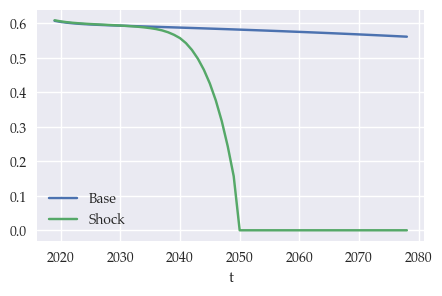

In [7]:
tPlot = M.db('t')[0:60]
adj.rc_pd(pd.DataFrame({'Base': db0('qCO2agg'), 'Shock': sol('qCO2agg')}), tPlot).plot(figsize=(5,3));

### SYT hotelling rule

<Axes: xlabel='t'>

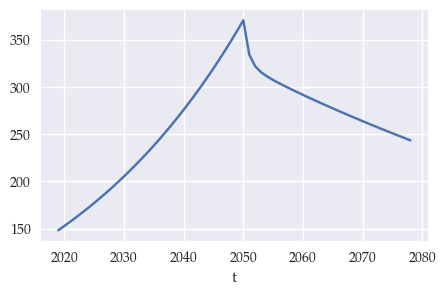

In [8]:
M.updateRegulation('SYT_HR')
solHR = M.jSolve(25, state='B')
adj.rc_pd(solHR('tauCO2agg'), tPlot).plot(figsize=(5,3))

### Linear reduction path

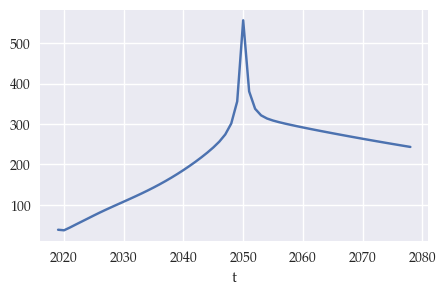

In [9]:
M.updateRegulation('LRP')
solLRP = M.jSolve(25, state = 'B')
adj.rc_pd(solLRP('tauCO2agg'), tPlot).plot(figsize=(5,3));

### Emission budget with hotelling rule

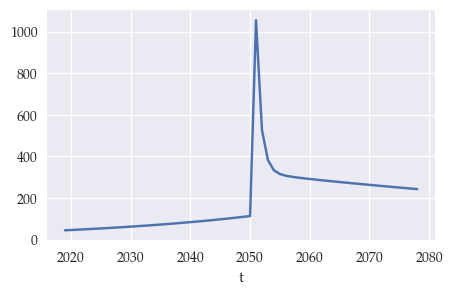

In [10]:
M.updateRegulation('EB_HR')
solEB = M.solve()
adj.rc_pd(solEB('tauCO2agg'), tPlot).plot(figsize=(5,3));

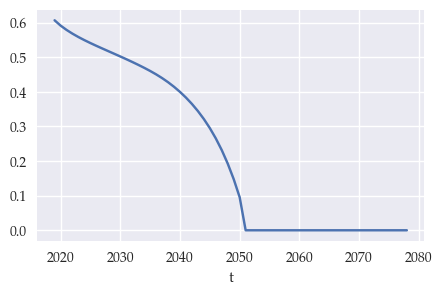

In [11]:
adj.rc_pd(solEB('qCO2agg'), tPlot).plot(figsize=(5,3));

### SYT with "OPT" policy:

Start from SYT model:

In [12]:
[M.db.__setitem__(k, sol[k]) for k in M.db.getTypes(['var']) if k in sol.symbols]; # use solution database
M.updateRegulation('SYT_OPT') # set to optimal

Solve (it works, but it is difficult, it seems):

In [14]:
solSYT_opt = M.solve()

### EB with "OPT" policy:

Start from EB model:

In [15]:
[M.db.__setitem__(k, solEB[k]) for k in M.db.getTypes(['var']) if k in solEB.symbols]; # use solution database
M.updateRegulation('EB_OPT') # set to optimal

In [17]:
solEB_opt = M.solve()